# Imports & basic configuration

In [1]:
try:
    # always cd to the right directory in google colab
    from google.colab import drive
    drive.mount('/content/drive')
    %cd "/content/drive/MyDrive/Colab Notebooks/branch_full/deep_branching"
except:
    pass

import math
from scipy import special
import numpy as np
import torch
import matplotlib.pyplot as plt
import time
from branch import Net
import logging
from pynverse import inversefunc

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [2]:
# perfect reproducibility is not guaranteed with different version of torch
#
import torchaudio
import torchvision

print(f"torch version: {torch.__version__}")
print(f"torchaudio version: {torchaudio.__version__}")
print(f"torchvision version: {torchvision.__version__}")

torch version: 1.11.0+cu113
torchaudio version: 0.11.0+cu113
torchvision version: 0.12.0+cu113


In [3]:
print("Information of the allocated GPU.")
!nvidia-smi

Information of the allocated GPU.
Fri May 20 22:31:11 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 510.60.02    Driver Version: 510.60.02    CUDA Version: 11.6     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ...  Off  | 00000000:07:00.0  On |                  N/A |
| 50%   60C    P5    53W / 350W |    194MiB / 12288MiB |      5%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                      

# Taylor-Green

In [4]:
# function definition
deriv_map = np.array(
    [
        [1, 0],  # for nabla p
        [0, 1],
        [0, 0],  # for u
        [0, 0],
        [1, 0],  # for nabla u1
        [0, 1],
        [1, 0],  # for nabla u2
        [0, 1],
    ]
)
zeta_map = np.array([-1, -1, 0, 1, 0, 0, 1, 1])
deriv_condition_deriv_map = np.array(
    [
        [1, 0],
        [0, 1],
    ]
)
deriv_condition_zeta_map = np.array([0, 1])
_, dim = deriv_map.shape

def f_example(y, coordinate):
    """
    idx 0 -> no deriv
    """
    f = -y[coordinate]
    for j in range(dim):
        f += -y[dim + j] * y[2 * dim + dim * coordinate + j]
    return f

def phi_example(x, coordinate):
    if coordinate == 0:
        return -torch.cos(x[0]) * torch.sin(x[1])
    else:
        return torch.sin(x[0]) * torch.cos(x[1])

problem_name = "taylor_green_2d"
t_lo, x_lo, x_hi = 0., 0, 2 * math.pi

## T = .25, nu = 2

In [5]:
T, nu = .25, 2
def exact_example(t, x, T, i):
    if i == 0:
        return -np.cos(x[0]) * np.sin(x[1]) * np.exp(-nu * (T - t))
    else:
        return np.sin(x[0]) * np.cos(x[1]) * np.exp(-nu * (T - t))

Patch 0: generation of p samples take 34.43255305290222 seconds.
Patch  0: epoch    0 with loss 2.95E+00
Patch  0: epoch  500 with loss 6.35E-03
Patch  0: epoch 1000 with loss 3.98E-03
Patch  0: epoch 1500 with loss 1.42E-03
Patch  0: epoch 2000 with loss 1.21E-03
Patch  0: epoch 2500 with loss 1.22E-03
Patch  0: epoch 2999 with loss 1.20E-03
Patch0: pre-training of p with 3000 epochs takes   50 seconds.
Patch 0: generation of u samples take 111.19200801849365 seconds.
Patch  0: epoch    0 with loss 7.24E-01
Patch  0: epoch  500 with loss 3.75E-02
Patch  0: epoch 1000 with loss 3.58E-02
Patch  0: epoch 1500 with loss 3.51E-02
Patch  0: epoch 2000 with loss 3.51E-02
Patch  0: epoch 2500 with loss 3.51E-02
Patch  0: epoch 2999 with loss 3.51E-02
Patch 0: training of u with 3000 epochs take 34.469738721847534 seconds.


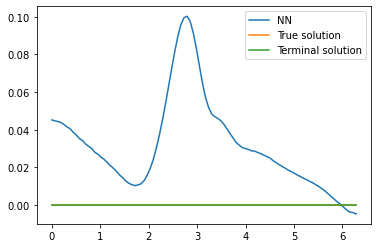

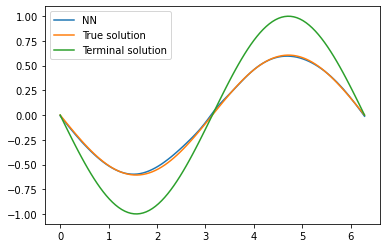

In [7]:
torch.manual_seed(0)
model = Net(
    problem_name=problem_name,
    f_fun=f_example,
    deriv_map=deriv_map,
    zeta_map=zeta_map,
    deriv_condition_deriv_map=deriv_condition_deriv_map,
    deriv_condition_zeta_map=deriv_condition_zeta_map,
    phi_fun=phi_example,
    device=device,
    x_lo=x_lo,
    x_hi=x_hi,
    T=T,
    verbose=True,
    nu=nu,
    branch_nb_path_per_state=1000,
    branch_nb_states=100000,
    branch_nb_states_per_batch=1000,
    fix_all_dim_except_first=False,
    epochs=10000,
    lr_gamma=0.1,
    branch_lr=1e-2,
    branch_activation="tanh",
    neurons=100,
    layers=2,
)
model.train_and_eval()
model.compare_with_exact(exact_fun=exact_example)

## T = 1, nu = .2

In [ ]:
T, nu = 1, .2
def exact_example(t, x, T, i):
    if i == 0:
        return -np.cos(x[0]) * np.sin(x[1]) * np.exp(-nu * (T - t))
    else:
        return np.sin(x[0]) * np.cos(x[1]) * np.exp(-nu * (T - t))

In [ ]:
torch.manual_seed(0)
model = Net(
    problem_name=problem_name,
    f_fun=f_example,
    deriv_map=deriv_map,
    zeta_map=zeta_map,
    deriv_condition_deriv_map=deriv_condition_deriv_map,
    deriv_condition_zeta_map=deriv_condition_zeta_map,
    phi_fun=phi_example,
    device=device,
    x_lo=x_lo,
    x_hi=x_hi,
    T=T,
    verbose=True,
    nu=nu,
    branch_nb_path_per_state=1000,
    branch_nb_states=100000,
    branch_nb_states_per_batch=1000,
    fix_all_dim_except_first=False,
    epochs=10000,
    lr_gamma=0.1,
    branch_lr=1e-2,
    branch_activation="tanh",
    neurons=100,
    layers=2,
)
model.train_and_eval()
model.compare_with_exact(exact_fun=exact_example)

## T = 10, nu = .02

In [ ]:
T, nu = 10, .02
def exact_example(t, x, T, i):
    if i == 0:
        return -np.cos(x[0]) * np.sin(x[1]) * np.exp(-nu * (T - t))
    else:
        return np.sin(x[0]) * np.cos(x[1]) * np.exp(-nu * (T - t))

In [ ]:
torch.manual_seed(0)
model = Net(
    problem_name=problem_name,
    f_fun=f_example,
    deriv_map=deriv_map,
    zeta_map=zeta_map,
    deriv_condition_deriv_map=deriv_condition_deriv_map,
    deriv_condition_zeta_map=deriv_condition_zeta_map,
    phi_fun=phi_example,
    device=device,
    x_lo=x_lo,
    x_hi=x_hi,
    T=T,
    verbose=True,
    nu=nu,
    branch_nb_path_per_state=1000,
    branch_nb_states=100000,
    branch_nb_states_per_batch=1000,
    fix_all_dim_except_first=False,
    epochs=10000,
    lr_gamma=0.1,
    branch_lr=1e-2,
    branch_activation="tanh",
    neurons=100,
    layers=2,
)
model.train_and_eval()
model.compare_with_exact(exact_fun=exact_example)

# ABC

In [4]:
A = B = C = 0.5

# function definition
deriv_map = np.array(
    [
        [1, 0, 0],  # for nabla p
        [0, 1, 0],
        [0, 0, 1],
        [0, 0, 0],  # for u
        [0, 0, 0],
        [0, 0, 0],
        [1, 0, 0],  # for nabla u1
        [0, 1, 0],
        [0, 0, 1],
        [1, 0, 0],  # for nabla u2
        [0, 1, 0],
        [0, 0, 1],
        [1, 0, 0],  # for nabla u3
        [0, 1, 0],
        [0, 0, 1],
    ]
)
zeta_map = np.array([-1, -1, -1, 0, 1, 2, 0, 0, 0, 1, 1, 1, 2, 2, 2])
deriv_condition_deriv_map = np.array(
    [
        [1, 0, 0],
        [0, 1, 0],
        [0, 0, 1],
    ]
)
deriv_condition_zeta_map = np.array([0, 1, 2])

_, dim = deriv_map.shape

def f_example(y, coordinate):
    """
    idx 0 -> no deriv
    """
    f = -y[coordinate]
    for j in range(dim):
        f += -y[dim + j] * y[2 * dim + dim * coordinate + j]
    return f

def phi_example(x, coordinate):
    if coordinate == 0:
        return A * torch.sin(x[2]) + C * torch.cos(x[1])
    elif coordinate == 1:
        return B * torch.sin(x[0]) + A * torch.cos(x[2])
    else:
        return C * torch.sin(x[1]) + B * torch.cos(x[0])

problem_name = "abd_3d"
t_lo, x_lo, x_hi = 0., 0, 2 * math.pi

## T = .7, nu = .02

In [ ]:
T, nu = .7, .02
def exact_example(t, x, T, i):
    if i == 0:
        return -np.cos(x[0]) * np.sin(x[1]) * np.exp(-nu * (T - t))
    else:
        return np.sin(x[0]) * np.cos(x[1]) * np.exp(-nu * (T - t))

In [ ]:
torch.manual_seed(0)
model = Net(
    problem_name=problem_name,
    f_fun=f_example,
    deriv_map=deriv_map,
    zeta_map=zeta_map,
    deriv_condition_deriv_map=deriv_condition_deriv_map,
    deriv_condition_zeta_map=deriv_condition_zeta_map,
    phi_fun=phi_example,
    device=device,
    x_lo=x_lo,
    x_hi=x_hi,
    T=T,
    verbose=True,
    nu=nu,
    branch_nb_path_per_state=1000,
    branch_nb_states=100000,
    branch_nb_states_per_batch=1000,
    fix_all_dim_except_first=False,
    epochs=10000,
    lr_gamma=0.1,
    branch_lr=1e-2,
    branch_activation="tanh",
    neurons=100,
    layers=2,
)
model.train_and_eval()
model.compare_with_exact(exact_fun=exact_example)

## T = .7, nu = .0002

In [ ]:
T, nu = .7, .0002
def exact_example(t, x, T, i):
    if i == 0:
        return -np.cos(x[0]) * np.sin(x[1]) * np.exp(-nu * (T - t))
    else:
        return np.sin(x[0]) * np.cos(x[1]) * np.exp(-nu * (T - t))

In [ ]:
torch.manual_seed(0)
model = Net(
    problem_name=problem_name,
    f_fun=f_example,
    deriv_map=deriv_map,
    zeta_map=zeta_map,
    deriv_condition_deriv_map=deriv_condition_deriv_map,
    deriv_condition_zeta_map=deriv_condition_zeta_map,
    phi_fun=phi_example,
    device=device,
    x_lo=x_lo,
    x_hi=x_hi,
    T=T,
    verbose=True,
    nu=nu,
    branch_nb_path_per_state=1000,
    branch_nb_states=100000,
    branch_nb_states_per_batch=1000,
    fix_all_dim_except_first=False,
    epochs=10000,
    lr_gamma=0.1,
    branch_lr=1e-2,
    branch_activation="tanh",
    neurons=100,
    layers=2,
)
model.train_and_eval()
model.compare_with_exact(exact_fun=exact_example)